## Import

In [1]:
# helper functions
import sys
sys.path.append('../helper_functions')
from get_epsilon_subset import get_epsilon_subset

# utils functions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ot # for Sliced Wasserstein Distance (SWD)

# tensorflow for deep learning
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# sklearn for preprocessing
from sklearn.preprocessing import StandardScaler

In [2]:
data = get_epsilon_subset('../data')

## 1. Data Analysis

In [3]:
YIELD = data[['YIELD_1', 'YIELD_2', 'YIELD_3', 'YIELD_4',]]
print('YIELD.shape: ', YIELD.shape)
print()
print(YIELD.head())

YIELD.shape:  (1000, 4)

   YIELD_1  YIELD_2  YIELD_3  YIELD_4
0     5.54     6.61    10.39     5.77
1     4.39     6.86     8.49     8.65
2     4.07     6.04     6.12     6.34
3     4.77     6.08    10.60     3.93
4     4.40     3.51     8.60     5.58


In [4]:
# describe the data
print(YIELD.describe())

           YIELD_1      YIELD_2      YIELD_3      YIELD_4
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      5.364950     6.168970     9.389020     3.316930
std       1.260088     1.680144     1.791007     1.927254
min       2.350000     0.000000     3.910000     0.000000
25%       4.370000     4.877500     8.280000     1.940000
50%       5.160000     6.005000     9.490000     3.150000
75%       6.082500     7.332500    10.690000     4.500000
max      10.380000    10.700000    14.030000     9.620000


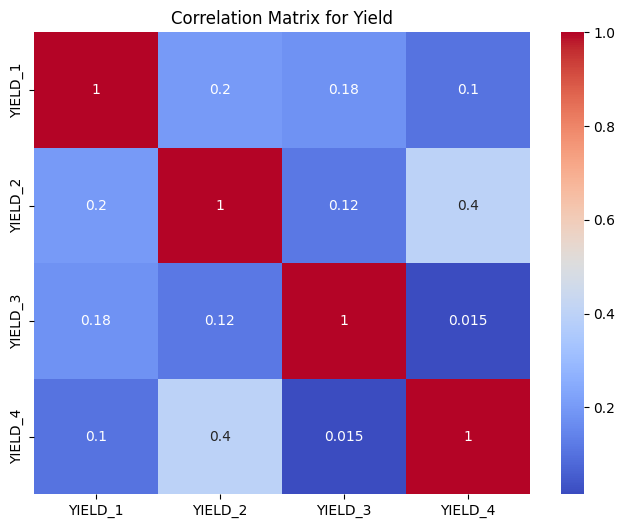

In [5]:
# correlation matrix
corr_matrix = YIELD.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Yield')
plt.show()

* Not a big correlation between variables


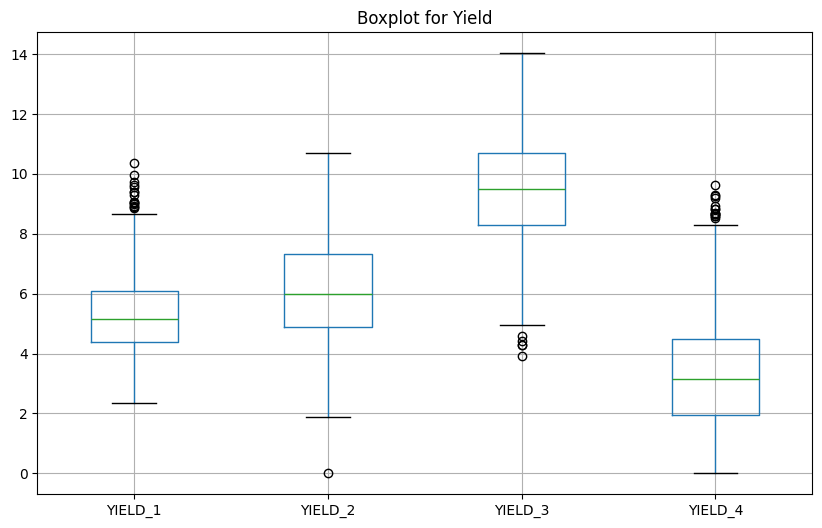

In [6]:
# boxplot
plt.figure(figsize=(10, 6))
YIELD.boxplot(grid=True)
plt.title('Boxplot for Yield')
plt.show()

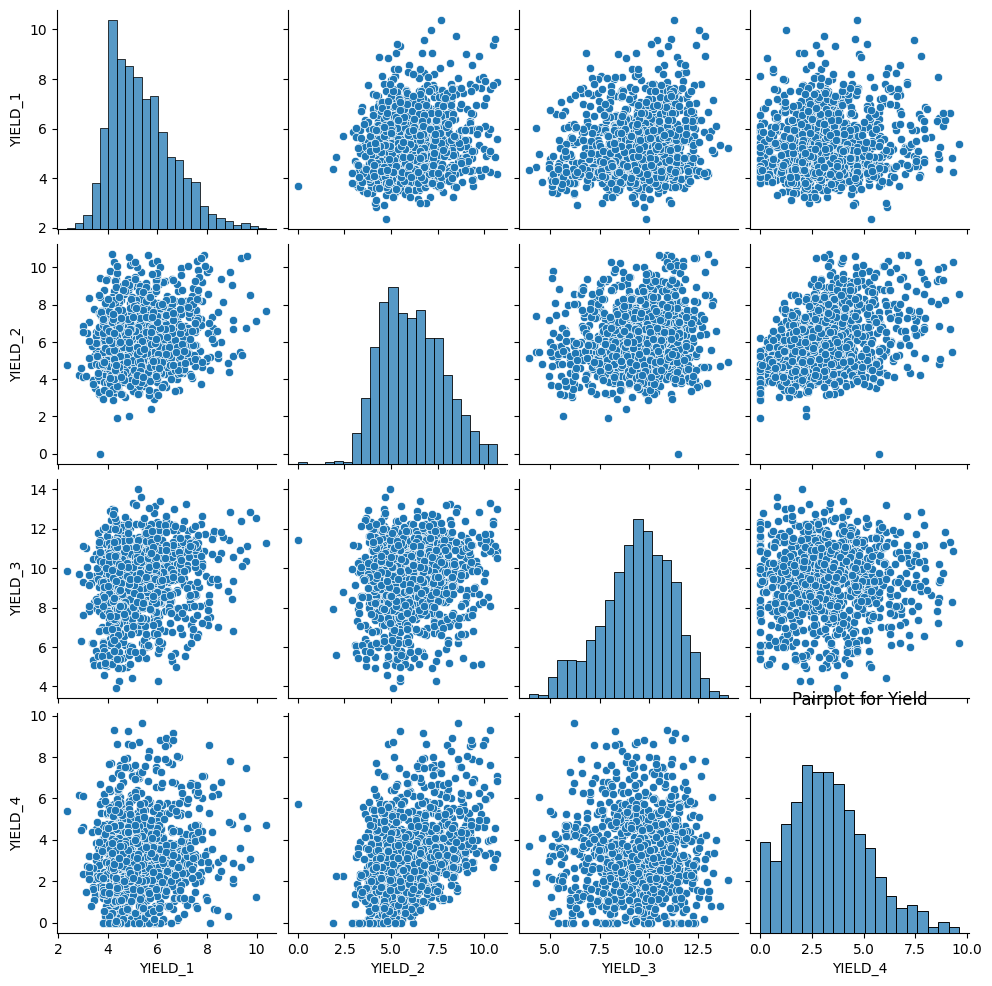

In [7]:
# pairplot graph
sns.pairplot(YIELD)
plt.title('Pairplot for Yield')
plt.show()

* seems to be a gaussian distribution

In [8]:
YIELD.head()

,YIELD_1,YIELD_2,YIELD_3,YIELD_4
0,5.54,6.61,10.39,5.77
1,4.39,6.86,8.49,8.65
2,4.07,6.04,6.12,6.34
3,4.77,6.08,10.60,3.93
4,4.40,3.51,8.60,5.58


## 2. FIRST GAN -- baseline

In [9]:
# normalize the data
scaler = StandardScaler()
YIELD_scaled = scaler.fit_transform(YIELD)
print(YIELD_scaled.shape)

(1000, 4)


In [10]:
# discriminator model
def build_generator(latent_dim):
    dtype = 'float64'
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, dtype=dtype))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512, dtype=dtype))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024, dtype=dtype))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(4, dtype=dtype,activation="linear"))  # (YIELD_1, YIELD_2, YIELD_3, YIELD_4)
    return model

In [11]:
# discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(512, input_shape=(4,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

In [12]:
# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
# Optimizers
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

In [14]:
class YieldGAN(Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(YieldGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

    def compile(self, generator_optimizer, discriminator_optimizer, loss_fn):
        super(YieldGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_data):
        # get the batch size
        batch_size = tf.shape(real_data)[0]

        # generate random YIELD data
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_data = self.generator(random_noise)

        # concatenate real and generated data
        combined_data = tf.concat([generated_data, real_data], axis=0)

        # labels for generated and real data
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # add noise to the labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_data)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.discriminator_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # create the labels
        misleading_labels = tf.zeros((batch_size, 1))

        # train the generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_noise))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.generator_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [15]:
# Parameters
latent_dim = 50
epochs = 5000
batch_size = 128
buffer_size = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()

In [16]:
# Build an instance of the GAN
yield_gan = YieldGAN(generator, discriminator, latent_dim)

# Compile the model
yield_gan.compile(generator_optimizer, discriminator_optimizer, cross_entropy)

# batch and shuffling the data
train_dataset = tf.data.Dataset.from_tensor_slices(YIELD_scaled).shuffle(buffer_size).batch(batch_size)

In [17]:
# train the model
yield_gan.fit(train_dataset, epochs=epochs)

Epoch 1/5000


/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 1s 10ms/step - d_loss: 0.6881 - g_loss: 0.6731
Epoch 2/5000
8/8 [==============================] - 0s 10ms/step - d_loss: 0.6560 - g_loss: 0.6955
Epoch 3/5000
8/8 [==============================] - 0s 10ms/step - d_loss: 0.6357 - g_loss: 0.7167
Epoch 4/5000
8/8 [==============================] - 0s 10ms/step - d_loss: 0.6530 - g_loss: 0.6816
Epoch 5/5000
8/8 [==============================] - 0s 10ms/step - d_loss: 0.6719 - g_loss: 0.6624
Epoch 6/5000
8/8 [==============================] - 0s 10ms/step - d_loss: 0.6558 - g_loss: 0.7362
Epoch 7/5000
8/8 [==============================] - 0s 10ms/step - d_loss: 0.6048 - g_loss: 0.8693
Epoch 8/5000
8/8 [==============================] - 0s 11ms/step - d_loss: 0.6413 - g_loss: 0.8309
Epoch 9/5000
8/8 [==============================] - 0s 13ms/step - d_loss: 0.8488 - g_loss: 0.5737
Epoch 10/5000
8/8 [==============================] - 0s 10ms/step - d_loss: 1.0464 - g_loss: 0.4109
Epoch 11/5000
8/8 [===

## 3. Compare the generated data with the real data with SWD

In [18]:
# generate random noise
noise = tf.random.normal(shape=(10000, latent_dim))

# generate YIELD data
generated_YIELD = generator(noise)

# inverse transform the data
generated_YIELD = scaler.inverse_transform(generated_YIELD)

# convert to dataframe
generated_YIELD = pd.DataFrame(generated_YIELD, columns=['YIELD_1', 'YIELD_2', 'YIELD_3', 'YIELD_4'])

In [19]:
# Sliced Wasserstein Distance (SWD)
swd_distance = ot.sliced.sliced_wasserstein_distance(YIELD.values, generated_YIELD.values, seed=123)
print(swd_distance)

1.9444659109425806
